# Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Increase the quality and resolution of our charts so we can copy/paste or justdirectly save from here.
# See: https://ipython.org/ipython-doc/3/api/generated/IPython.display.html
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=100)

# You can also just do this in Colab/Jupyter, some "magic":
# %config InlineBackend.figure_format='retina'

In [2]:
# Set style for all graphs
plt.style.use('fivethirtyeight')

In [3]:
# Import in data
df = pd.read_json('../sentiment_classification/updated_mongo_dataset.json')
df = df[['source', 'sentiment_category', 'url']]
df.head()

,source,sentiment_category,url
0,NBC News,negative,https://www.nbcnews.com/think/opinion/biden-s-...
1,NBC News,neutral,https://www.nbcnews.com/news/latino/first-lati...
2,NBC News,neutral,https://www.nbcnews.com/news/asian-america/ton...
3,NBC News,neutral,https://www.nbcnews.com/politics/immigration/s...
4,NBC News,negative,https://www.nbcnews.com/politics/politics-news...


## Data Processing
Add in political bias score and create sentiment categories based on compound sentiment scores.

In [4]:
# Political bias scores were derived from the Pew Research Center survey data
pol_bias_score = {'ABC News': -1.7, 'Al Jazeera English': -4.4, 'Bloomberg': -1.8, 'Breitbart News': 2.9, 'Buzzfeed': -3.5, 'CBS News': -1.6, 'CNN': -2.2, 'Fox News': 2, 'Google News': -1.3, 'MSNBC': -2.4, 'NBC News': -2.1, 'Politico': -3.5, 'The Huffington Post': -3.6, 'The Wall Street Journal': -0.25, 'The Washington Post': -3.7, 'USA Today': -1.3}

# Check that spelling is exactly the same for all source names
sources = df['source'].unique()
for source in sources:
    if source in pol_bias_score.keys():
        print("True")
    else:
        print(f'{source} is not scored')

True
True
True
True
True
True
True
True
True


In [5]:
# Add political bias scores to data frame and save to csv
df['source_bias'] = 0
for source in pol_bias_score:
    df.loc[df['source'] == source, 'source_bias'] = pol_bias_score[source]
    
df.head()

,source,sentiment_category,url,source_bias
0,NBC News,negative,https://www.nbcnews.com/think/opinion/biden-s-...,-2.1
1,NBC News,neutral,https://www.nbcnews.com/news/latino/first-lati...,-2.1
2,NBC News,neutral,https://www.nbcnews.com/news/asian-america/ton...,-2.1
3,NBC News,neutral,https://www.nbcnews.com/politics/immigration/s...,-2.1
4,NBC News,negative,https://www.nbcnews.com/politics/politics-news...,-2.1


## Overall Sentiment

In [6]:
# Count of sentiment labels by news source
sentiments_grouped = df.groupby(['source', 'sentiment_category']).count().reset_index()

In [7]:
# Create new dataframe of count of headlines with each overall sentiment by source 
sentiment_new = pd.pivot_table(sentiments_grouped, index='source', columns='sentiment_category', values ='url')
sentiment_new

sentiment_category,negative,neutral,positive
source,,,
Al Jazeera English,211,119,36
Breitbart News,500,139,124
CBS News,60,63,13
CNN,163,118,71
Fox News,259,150,85
NBC News,156,139,79
Politico,63,34,21
The Washington Post,114,55,23
USA Today,124,93,81


In [14]:
# Determine percentage of each sentiment category
sentiment_new['total'] = sentiment_new['negative'] + sentiment_new['neutral'] + sentiment_new['positive']
sentiment_new['% Negative'] = sentiment_new['negative']/sentiment_new['total']*100
sentiment_new['% Neutral'] = sentiment_new['neutral']/sentiment_new['total']*100
sentiment_new['% Positive'] = sentiment_new['positive']/sentiment_new['total']*100

sentiment_filtered = sentiment_new[['% Negative', '% Neutral', '% Positive']].sort_values('% Negative')
sentiment_filtered

sentiment_category,% Negative,% Neutral,% Positive
source,,,
USA Today,41.610738,31.208054,27.181208
NBC News,41.711230,37.165775,21.122995
CBS News,44.117647,46.323529,9.558824
CNN,46.306818,33.522727,20.170455
Fox News,52.429150,30.364372,17.206478
Politico,53.389831,28.813559,17.796610
Al Jazeera English,57.650273,32.513661,9.836066
The Washington Post,59.375000,28.645833,11.979167
Breitbart News,65.530799,18.217562,16.251638


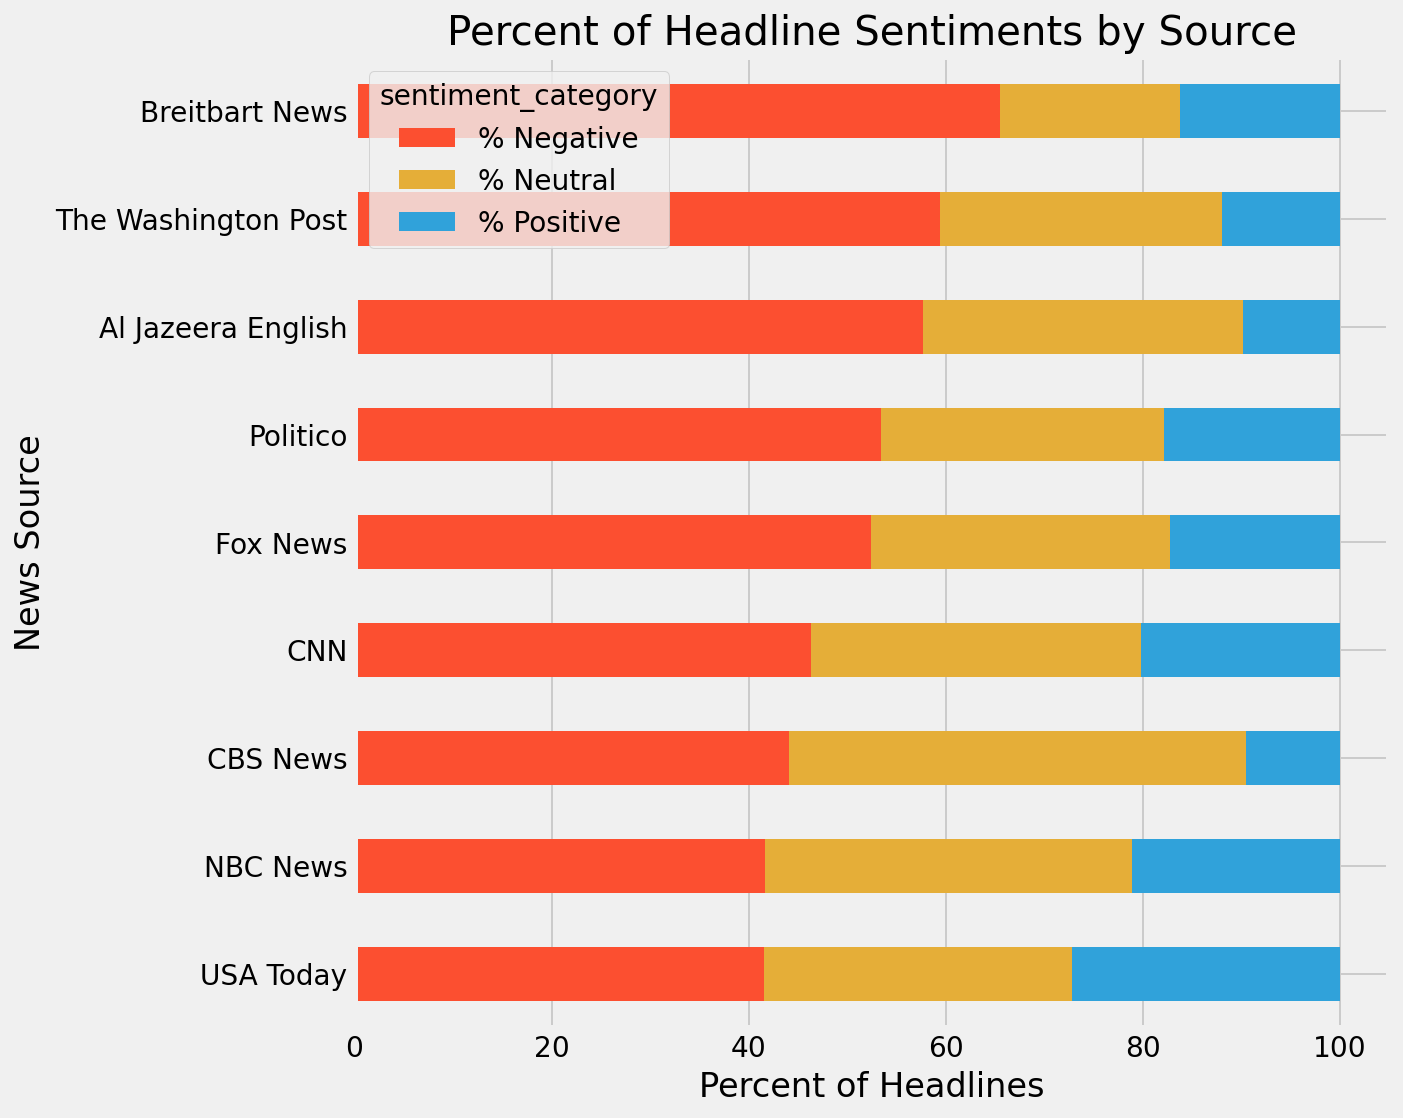

In [16]:
# Bar graph of number of sentiment score types by source
colors = ['#fc4f30', '#e5ae38', '#30a2da']
sentiment_filtered.plot.barh(figsize=(10, 8), title = 'Percent of Headline Sentiments by Source', color=colors, stacked='True')
plt.xlabel('Percent of Headlines')
plt.ylabel('News Source')
plt.tight_layout()
plt.savefig('../headlinesentimentspercent.png')

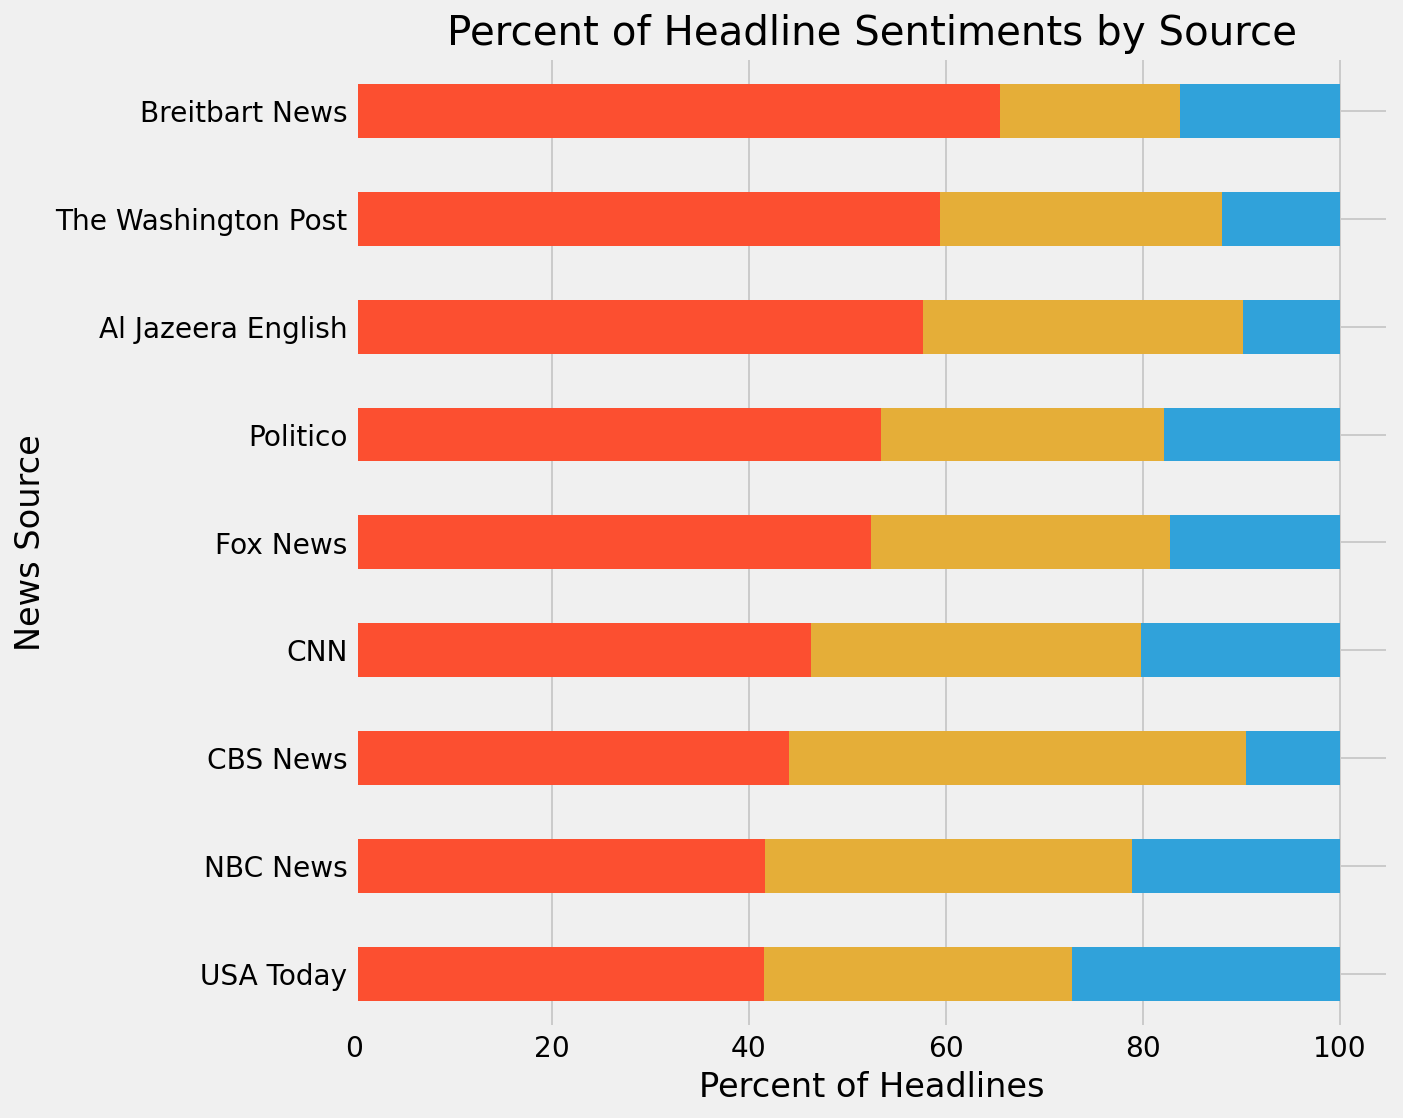

In [17]:
# Bar graph of number of sentiment score types by source
colors = ['#fc4f30', '#e5ae38', '#30a2da']
sentiment_filtered.plot.barh(figsize=(10, 8), title = 'Percent of Headline Sentiments by Source', color=colors, stacked='True', legend=None)
plt.xlabel('Percent of Headlines')
plt.ylabel('News Source')
plt.tight_layout()
plt.savefig('../headlinesentimentspercent.png')

## Bias vs. Sentiment

In [18]:
# Get bias for each source
df_bias = df[['source', 'source_bias']].drop_duplicates()
df_bias

,source,source_bias
0,NBC News,-2.1
77,Fox News,2.0
155,Breitbart News,2.9
255,CNN,-2.2
431,Politico,-3.5
549,The Washington Post,-3.7
1430,CBS News,-1.6
2150,Al Jazeera English,-4.4
2516,USA Today,-1.3


In [19]:
# Join with percentages of each sentiment category
df_bias_percs = df_bias.join(sentiment_filtered, on='source')
df_bias_percs

,source,source_bias,% Negative,% Neutral,% Positive
0,NBC News,-2.1,41.711230,37.165775,21.122995
77,Fox News,2.0,52.429150,30.364372,17.206478
155,Breitbart News,2.9,65.530799,18.217562,16.251638
255,CNN,-2.2,46.306818,33.522727,20.170455
431,Politico,-3.5,53.389831,28.813559,17.796610
549,The Washington Post,-3.7,59.375000,28.645833,11.979167
1430,CBS News,-1.6,44.117647,46.323529,9.558824
2150,Al Jazeera English,-4.4,57.650273,32.513661,9.836066
2516,USA Today,-1.3,41.610738,31.208054,27.181208


<AxesSubplot:>

C:\Users\rec42\Anaconda3\envs\PythonData\lib\site-packages\IPython\core\pylabtools.py:132: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


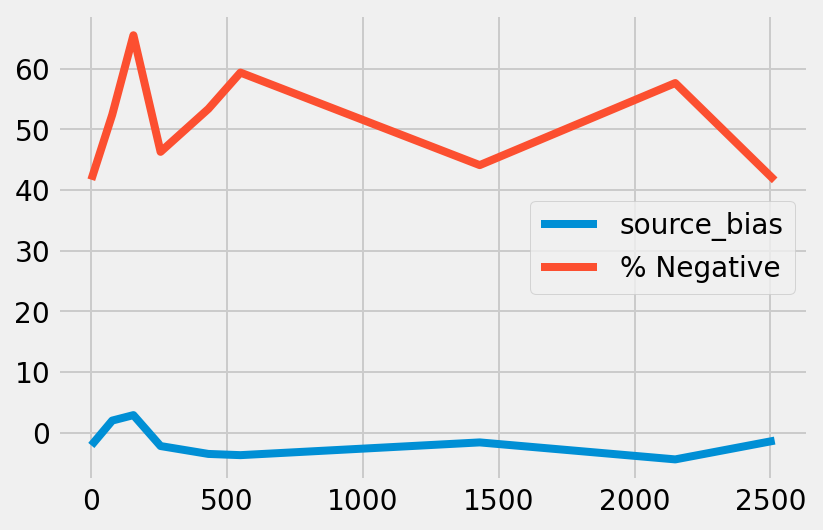

In [20]:
df_bias_percs[['source_bias', '% Negative']].plot()